In [60]:
import pandas as pd
import numpy as np

In [61]:
def cross_analysis_one_hot(cols_first:list, cols_second:list, df):
    
    """
    Perform cross analysis between two sets of one-hot encoded columns.

    This function calculates the sum and percentage of occurrences for each combination
    of values in two lists of columns within a given DataFrame. It's particularly useful
    for analyzing the relationship between two one-hot encoded questions by generating
    a new DataFrame that summarizes these relationships.

    Parameters:
    - cols_first (list of str): Column names to be used as the index of the new DataFrame.
        These columns should be one-hot encoded and represent the first question/set of options.
    - cols_second (list of str): Column names to be used as columns of the new DataFrame.
        These columns should be one-hot encoded and represent the second question/set of options.
    - df (pd.DataFrame, optional): The DataFrame containing the columns specified in
        `cols_first` and `cols_second`. Defaults to `df_whole` if not specified.

    Returns:
    - pd.DataFrame: A DataFrame with index as `cols_first` and columns as `cols_second`,
        containing sum and percentage values for each index-column combination.
    - list: A list of the names of the percentage columns in the returned DataFrame,
        which can be used for further analysis or visualization.

    Example:
    >>> cols_first = ['Question1_OptionA', 'Question1_OptionB']
    >>> cols_second = ['Question2_OptionA', 'Question2_OptionB']
    >>> analysis_df, percentage_cols = cross_analysis_one_hot(cols_first, cols_second, df=my_dataframe)
    This will return a DataFrame with the cross analysis of specified options and
    a list of column names representing the percentage values.
    """
    
    # initialize empty DataFrame
    aggregated_df = pd.DataFrame(index=cols_first, columns=cols_second).fillna(0)

    for level_index in cols_first:
        for level_cols in cols_second:
            # Sum the age counts for the current career path
            aggregated_df.loc[level_index, level_cols] = df[df[level_index] == True][level_cols].sum()
        
    # rename indices and column names
    aggregated_df.columns = cols_second

    #aggregated_df.index = career
    aggregated_df['totals'] = aggregated_df.sum(axis=1)
    
    ls_perc_columns = []
    for col in aggregated_df.loc[:, aggregated_df.columns != 'totals'].columns:
        percentage_column_name = f'{col}Percentage'
        ls_perc_columns.append(percentage_column_name)
        aggregated_df[percentage_column_name] = np.divide(aggregated_df[col], aggregated_df['totals'].replace(0, np.nan)) * 100
        
    
    
    return aggregated_df, ls_perc_columns

In [62]:
def cross_analysis_non_one_hot(col_name:str, oh_cols:list, df, transpose=False):
    
    """
    Performs aggregation and analysis on a dataset based on a specified non-one-hot-encoded column 
    against multiple one-hot-encoded columns. It calculates the sum and percentage of True values 
    for each one-hot-encoded column grouped by the unique values in the non-one-hot-encoded column.

    Parameters:
    - col_name (str): The name of the non-one-hot-encoded column to group the data by.
    - oh_cols (list of str): A list containing the names of the one-hot-encoded columns to be analyzed.
    - df (pd.DataFrame, optional): The DataFrame to perform the analysis on. Defaults to `df_whole`.
    - transpose (bool, optional): If set to True, the resulting DataFrame is transposed, 
      making the aggregated categories the columns instead of the rows. Defaults to False.

    Returns:
    - pd.DataFrame: A DataFrame with aggregated sum and percentage values for each category 
      in the non-one-hot-encoded column. If `transpose` is True, the DataFrame is transposed.
    - list: A list of the names of the percentage columns in the returned DataFrame, 
      which can be used for further analysis or visualization.

    The resulting DataFrame includes a 'totals' column that sums the occurrences for all 
    one-hot-encoded columns, and additional columns representing the percentage of each 
    one-hot-encoded column's True values relative to the 'totals'.

    Example:
    >>> col_name = 'Department'
    >>> oh_cols = ['ProjectCompleted', 'ProjectInProgress']
    >>> aggregated_df, percentage_cols = cross_analysis_non_one_hot(col_name, oh_cols, df=my_dataframe)
    >>> print(aggregated_df)
    
    This example would group `my_dataframe` by 'Department', aggregating data for 'ProjectCompleted' 
    and 'ProjectInProgress', and calculating the percentage of each within departments.
    """
    
    
    # Initialize aggregation dictionary
    agg_dict = {col: pd.NamedAgg(column=col, aggfunc='sum') for col in oh_cols}
    
    # Aggregate the data
    df_aggregated = df.groupby(col_name).agg(**agg_dict).reset_index()
    
    if not transpose:
        # Calculate totals
        df_aggregated['totals'] = df_aggregated[oh_cols].sum(axis=1)

        # Calculate percentages for each one-hot-encoded column
        ls_perc_columns = []
        for col in oh_cols:
            percentage_col = f'{col}Perc'
            ls_perc_columns.append(percentage_col)
            # Use numpy to handle division by zero
            df_aggregated[percentage_col] = np.divide(df_aggregated[col], df_aggregated['totals'].replace(0, np.nan)) * 100
            df_aggregated[percentage_col].fillna(0, inplace=True)  # Handle NaNs from division by zero
    else: 
        df_aggregated = df_aggregated.T
        df_aggregated.columns = [f"{df_aggregated.index[0]}_{df_aggregated.iloc[0, i]}_sum" for i in range(len(df_aggregated.columns))]
        df_aggregated.drop(index=df_aggregated.index[0], inplace=True)
        df_aggregated['totals'] = df_aggregated.sum(axis=1)
        
        ls_perc_columns = []
        for col in df_aggregated.columns[:-1]:  # Exclude 'totals' from the percentage calculation
            percentage_col = f'{col}Perc'
            ls_perc_columns.append(percentage_col)
            # Use numpy to handle division by zero
            df_aggregated[percentage_col] = np.divide(df_aggregated[col], df_aggregated['totals'].replace(0, np.nan)) * 100
            df_aggregated[percentage_col].fillna(0, inplace=True)  # Handle NaNs from division by zero

    return df_aggregated, ls_perc_columns

In [63]:
def inversed_legend(ax, ls_categories_legend):
    
    """
    Updates the plot's legend to reflect the inverse order of categories, aligning the legend order with the visual stacking order in a bar plot.

    This function is designed to work with matplotlib plots where the visual stacking order of elements is opposite to the desired legend order. It reverses the legend's label and handle order to match the plot's visual representation, ensuring that the legend accurately reflects the stacking order.

    Parameters:
    - ls_categories_legend (list of str): A list containing the labels for the legend in the desired order. This list will be reversed internally to match the visual stacking order in the plot.

    Notes:
    - The function assumes that the matplotlib Axes object `ax` is defined in the global scope or accessible in the calling context.
    - The legend's location is set to 'center left' with a bbox_to_anchor at (1, 0.75), which places the legend outside the plot area. Adjust these parameters as necessary to fit the plot layout.

    Example usage:
    ```python
    # Assuming a matplotlib plot has been created and `ax` is the current Axes object
    ls_categories_legend = ['Category 1', 'Category 2', 'Category 3']
    inversed_legend(ls_categories_legend)
    ```

    This function will reverse both the handles and labels of the legend to match the plot's visual stacking order, starting with 'Category 3' at the top and ending with 'Category 1' at the bottom.
    """

    # Reverse the order of labels to match the visual stacking order in the plot
    reversed_labels = ls_categories_legend[::-1]

    # Get the current handles from the plot
    handles, _ = ax.get_legend_handles_labels()

    # Reverse the order of handles to match the reversed order of labels
    reversed_handles = handles[::-1]

    # Set the new legend with reversed handles and labels
    ax.legend(reversed_handles, reversed_labels, loc='center left', bbox_to_anchor=(1, 0.75))

In [64]:
def stacked_bar_graph(df, cols_perc, title_name, ls_x_ticks:list, str_x_label:str, ls_legend_levels, dir_to_save, data_name, **kwargs):
    
    ax = df[cols_perc].plot(kind='bar', 
                            stacked=True,
                            figsize=kwargs.get('figsize', (8, 6)), 
                            #figsize=(8, 6),                                                                                        
                            xlabel=str_x_label,
                            width=0.9,
                            title=title_name
                                    )
    
    ax.set_ylabel('Prozent')

    # add percentage labels into the bars
    for c in ax.containers:
        # Optional: if the segment is small or 0, customize the labels
        labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
        # remove the labels parameter if it's not needed for customized labels
        ax.bar_label(c, fmt=lambda x: f'{x:.1f}' if x > 0 else '', label_type='center')
        
    ax.set_xticklabels(ls_x_ticks, rotation=kwargs.get('rotation', 45), ha='right', rotation_mode='anchor')

    inversed_legend(ax, ls_legend_levels)
        
    #add total values of entries above bar
    y_offset = 4
    for i, total in enumerate(df['totals']):
        ax.text(df['totals'].reset_index().index[i], y= 101, s = int(total), ha='center',
        weight='bold')

    ax.text(1.02, 0.985, 'Gesamtzahl', transform=ax.transAxes, fontsize=10, verticalalignment='top', weight='bold')
    
    fig = ax.get_figure()
    fig.savefig(f'{dir_to_save}{data_name}', bbox_inches='tight', dpi=300)

# Freie Wirtschaft

In [65]:
df_W= pd.read_csv('../data/processed/02_cleaned_data_W.csv')
df_W.head()

,Unnamed: 0,AP1. Wie alt sind Sie?,AP1. Wie alt sind Sie?_0.0,AP1. Wie alt sind Sie?_1.0,AP1. Wie alt sind Sie?_10.0,AP1. Wie alt sind Sie?_2.0,AP1. Wie alt sind Sie?_3.0,AP1. Wie alt sind Sie?_4.0,AP1. Wie alt sind Sie?_5.0,AP1. Wie alt sind Sie?_6.0,...,W7[SQ004]. Welche Form von Vergütung erhalten Sie? [Weihnachtsgeld],W7[SQ005]. Welche Form von Vergütung erhalten Sie? [Urlaubsgeld],W7[SQ006]. Welche Form von Vergütung erhalten Sie? [Sachwerte],W8[SQ001]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Arbeitszeitausgleich],W8[SQ002]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Bezahlung],W8[SQ003]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Sachwerte],W8[SQ004]. Wie werden zusätzlich geleistete Arbeitsstunden vergütet bzw. ausgeglichen? [Gar nicht],W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_1,W9. Bekommen Sie Ihre Vergütung pünktlich zum vertraglich vereinbarten Zeitpunkt?_Teils,id. Antwort ID
0,22,4.0,False,False,False,False,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,False,45
1,31,5.0,False,False,False,False,False,False,True,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,False,469
2,38,2.0,False,False,False,True,False,False,False,False,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,False,True,585
3,57,3.0,False,False,False,False,True,False,False,False,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,True,False,831
4,63,4.0,False,False,False,False,False,True,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,False,106


In [66]:
df_W.shape

(48, 238)

In [67]:
ls_cols_amount_contracts = [col for col in df_W.columns if col.startswith('W2.')]
print(ls_cols_amount_contracts)

['W2. Haben Sie regelmäßig mehrere Arbeitsstellen, Honorarverträge, Auftraggeber:innen oder Werkverträge gleichzeitig?']


In [68]:
df_amount_contracts = df_W[ls_cols_amount_contracts].value_counts(normalize=True).mul(100).to_frame().T
df_amount_contracts['totals'] = df_W[ls_cols_amount_contracts].value_counts().sum()
df_amount_contracts

"W2. Haben Sie regelmäßig mehrere Arbeitsstellen, Honorarverträge, Auftraggeber:innen oder Werkverträge gleichzeitig?",0.0,1.0,totals
proportion,66.666667,33.333333,48


In [70]:
df_amount_contracts.columns = ['Nein', 'Ja', 'totals']
df_amount_contracts

,Nein,Ja,totals
proportion,66.666667,33.333333,48


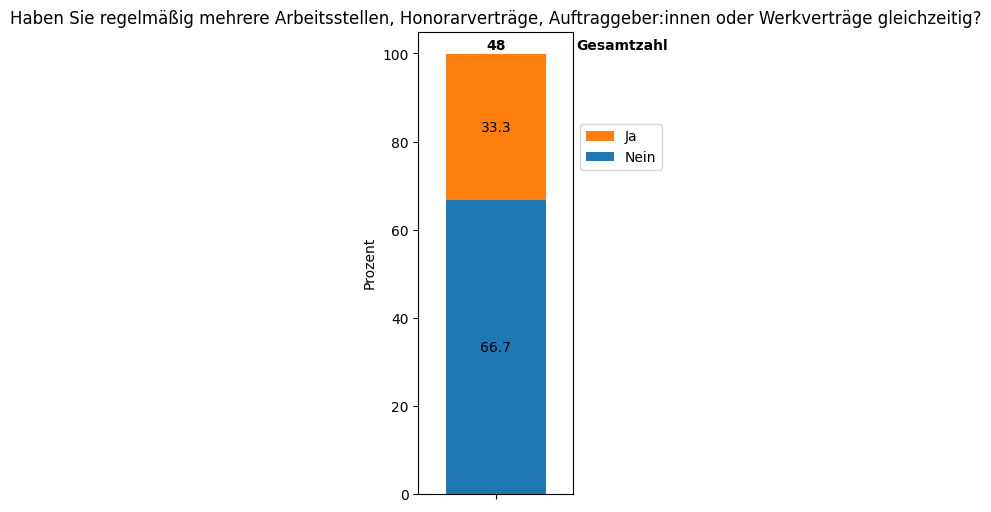

In [80]:
stacked_bar_graph(df_amount_contracts, 
                  cols_perc=['Nein', 'Ja'], 
                  title_name='Haben Sie regelmäßig mehrere Arbeitsstellen, Honorarverträge, Auftraggeber:innen oder Werkverträge gleichzeitig?', 
                  ls_x_ticks=[], 
                  str_x_label= None, 
                  ls_legend_levels=['Nein', 'Ja'],
                  dir_to_save='../reports/figures/non_academic/',
                  data_name='W_001_W2_Mehrere Verträge.png',
                  figsize=(2,6))

In [82]:
ls_cols_W15 = [col for col in df_W.columns if col.startswith('W15.')]
print(ls_cols_W15)
ls_cols_W14 = [col for col in df_W.columns if col.startswith('W14')]
print(ls_cols_W14)

['W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\xa0_Ja\u202f', 'W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\xa0_Nein\u202f', 'W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?\xa0_Unbekannt']
['W14[SQ001]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [1–9]', 'W14[SQ002]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [10–49]', 'W14[SQ003]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [50–249]', 'W14[SQ004]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [Mehr als 250 ]', 'W14[SQ005]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unterne

In [84]:
analysis_df, percentage_cols = cross_analysis_one_hot(ls_cols_W14, ls_cols_W15, df=df_W)
analysis_df

,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Ja,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Nein,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Unbekannt,totals,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Ja Percentage,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _Nein Percentage,W15. Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten? _UnbekanntPercentage
W14[SQ001]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [1–9],0,18,0,18,0.000000,100.000000,0.0
W14[SQ002]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [10–49],0,7,1,8,0.000000,87.500000,12.5
W14[SQ003]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [50–249],4,3,1,8,50.000000,37.500000,12.5
W14[SQ004]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [Mehr als 250 ],11,1,0,12,91.666667,8.333333,0.0
W14[SQ005]. Wie viele festangestellte Mitarbeiter:innen beschäftigt Ihr Unternehmen bzw. Betrieb (außer Inhaber:in)? [Unbekannt],1,1,0,2,50.000000,50.000000,0.0


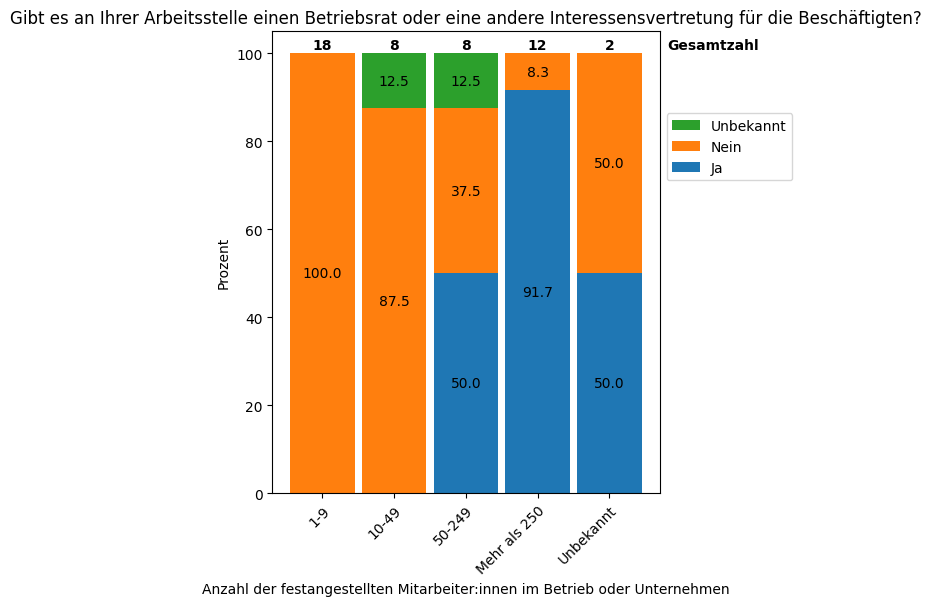

In [85]:
stacked_bar_graph(analysis_df, 
                  cols_perc=percentage_cols, 
                  title_name='Gibt es an Ihrer Arbeitsstelle einen Betriebsrat oder eine andere Interessensvertretung für die Beschäftigten?', 
                  ls_x_ticks=['1-9', '10-49', '50-249', 'Mehr als 250', 'Unbekannt'], 
                  str_x_label='Anzahl der festangestellten Mitarbeiter:innen im Betrieb oder Unternehmen', 
                  ls_legend_levels=['Ja', 'Nein', 'Unbekannt'],
                  dir_to_save='../reports/figures/non_academic/',
                  data_name='W_002_W14_W15_Mitarbeitervertretung.png',
                  figsize=(5,6))